<h1 style="color: #cd36d5ff">Видос в YAML</h1>


In [ ]:
# https://github.com/deepinvalue/video_annotations_to_yolo
"""
This script processes video annotations created using Label Studio, converting them into a
format suitable for the YOLO object detection model. The script has the capability to interpolate
bounding boxes for each intermediate frame based on key-frame annotations (as needed), and export
these labels (i.e., bounding box coordinates), along with the corresponding frames, into a
YOLO-compatible format. As it stands with Label Studio version 1.7.0, such functionality isn't
inherently available. Please note that video annotations should be exported in the JSON-MIN format.
"""

import argparse
import json
import csv
import copy
import cv2
from decimal import Decimal
from pathlib import Path
from tqdm import tqdm


def linear_interpolation(prev_seq, seq, label):
    # Define the start and end frame numbers
    a0 = prev_seq["frame"]
    a1 = seq["frame"]
    frames_info = dict()
    # Loop over all intermediate frames
    for frame in range(a0 + 1, a1):
        t = Decimal(frame - a0) / Decimal(a1 - a0)
        info = [label]
        # Interpolate bounding box dimensions for the current frame
        for b0, b1 in ((prev_seq[k], seq[k]) for k in ("x", "y", "width", "height")):
            info.append(str(b0 + t * (b1 - b0)))
        # Add interpolated information for the current frame to 'frames_info'
        frames_info[frame] = info
    return frames_info


def main(json_path, video_path, output_base):
    print("Parsing annotations from JSON")
    # Open the annotation file, which should be exported in "JSON-MIN" format
    with open(json_path) as f:
        video_labels = json.load(f, parse_float=Decimal)

    labels = set()
    for subject in video_labels[1]["box"]:
        labels.add(*subject["labels"])
    labels_dict = {k: i for i, k in enumerate(sorted(labels))}

    # Initialize dictionaries to store file information and frame timestamps
    files_dict = dict()
    frame_times = dict()

    # Loop over the subjects, i.e. football players in a match
    for subject in copy.deepcopy(video_labels[1]["box"]):
        # Get the subject labels (e.g. team-A, team-B, referee, ball)
        subject_labels = subject["labels"]

        # Map the label to its integer representation
        if len(subject_labels) == 1:
            label = labels_dict[subject_labels[0]]
        else:
            raise ValueError("Each subject must have exactly one label.")

        prev_seq = None

        # Process each sequence in the subject's timeline
        for seq in subject["sequence"]:
            frame = seq["frame"]

            # Adjust the x and y coordinates to be the center of the bounding box
            seq["x"] += seq["width"] / Decimal("2")
            seq["y"] += seq["height"] / Decimal("2")

            # Adjust the scale of bounding box dimensions
            for k in ("x", "y", "width", "height"):
                seq[k] /= Decimal("100")

            # If the current sequence is not adjacent to the previous sequence, perform linear interpolation
            if (
                (prev_seq is not None)
                and prev_seq["enabled"]
                and (frame - prev_seq["frame"] > 1)
            ):
                lines = linear_interpolation(prev_seq, seq, label)
            else:
                lines = dict()

            # Create the bounding box information line for the current frame
            lines[frame] = [label] + [
                str(seq[k]) for k in ("x", "y", "width", "height")
            ]

            # Add the bounding box information line to the corresponding frame in 'files_dict'
            for frame, info in lines.items():
                if frame in files_dict:
                    files_dict[frame].append(info)
                else:
                    files_dict[frame] = [info]

            # Store the timestamp for the current frame
            frame_times.update({frame: float(seq["time"])})

            prev_seq = seq

    # Sort the file information and frame timestamp dictionaries
    files_dict = dict(sorted(files_dict.items()))
    frame_times = dict(sorted(frame_times.items()))

    print("Exporting annotations in YOLO format")

    # Prepare YOLO directory structure
    output_path = Path(output_base)
    [
        (output_path / p).mkdir(parents=True, exist_ok=True)
        for p in ("images/", "labels/")
    ]

    # Write the YOLO classes
    with open(output_path / f"classes.txt", "w") as f:
        f.writelines(f"{line}\n" for line in labels_dict)

    max_frame = max(files_dict.keys())
    padding = len(str(max_frame))

    # Write the YOLO labels
    for frame, lines in files_dict.items():
        with open(
            output_path / "labels" / f"frame_{frame:0{padding}d}.txt", "w"
        ) as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=" ")
            csvwriter.writerows(lines)

    # Extract the Frames
    if video_path is not None:
        vidcap = cv2.VideoCapture(video_path)
        print(f"Extracting frames")
        for frame in tqdm(files_dict):
            vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame - 1)
            success, image = vidcap.read()
            if success:
                cv2.imwrite(
                    str(output_path / "images" / f"frame_{frame:0{padding}d}.jpg"),
                    image,
                )
            else:
                print(f"Unable to read frame {frame}. Quiting.")
                break

    print("Process finished successfully.")


if __name__ == "__main__":
    # parser = argparse.ArgumentParser(
    #     description="""This script processes video annotations exported from Label Studio
    #     in JSON-MIN format, converting them into a YOLO-compatible format. The script supports
    #     interpolation of bounding boxes for intermediate frames based on key-frame annotations
    #     and exports these labels along with corresponding frames (if a video path is provided).""",
    #     formatter_class=argparse.ArgumentDefaultsHelpFormatter
    # )
    # parser.add_argument("-j", "--json_path", required=True, help="Path to JSON annotations")
    # parser.add_argument("-v", "--video_path", default=None, help="Optional path to video file." \
    #                                                              " If provided, corresponding frames will be extracted.")
    # parser.add_argument("-o", "--output_base", default='output/', help="Path to output base directory")
    # args = parser.parse_args()

    json_path = r"D:\Datasets\EVE\mining_asteroid_01.json"
    video_path = r"D:\Datasets\EVE\mining_asteroid_01.mp4"
    output_base = r"D:\Projects\Eve-Online-Mining-Bot\Find interface elements\data\mining_asteroid_01"
    main(json_path, video_path, output_base)

Parsing annotations from JSON
Exporting annotations in YOLO format
Extracting frames


100%|██████████| 8670/8670 [12:52<00:00, 11.22it/s]

Process finished successfully.


<h1 style="color: #cd36d5ff">Починить индексы</h1>


In [ ]:
from pathlib import Path

ROOT = Path(r".\data\mining_asteroid_01\labels")  # корень, где train/ val/ test/
REMAP = {4: 0, 5: 1, 0: 2, 1: 3, 2: 5, 3: 4}

for txt in ROOT.rglob("*.txt"):
    lines = txt.read_text(encoding="utf-8").splitlines()
    out = []
    for ln in lines:
        if not ln.strip():
            continue
        parts = ln.split()
        old = int(parts[0])
        if old not in REMAP:
            # реши: пропускать, оставлять как есть или падать с ошибкой
            # out.append(ln); continue
            continue
        parts[0] = str(REMAP[old])
        out.append(" ".join(parts))
    txt.write_text("\n".join(out), encoding="utf-8")
print("Done")


Done


<h1 style="color: #cd36d5ff">Создать валидирующие данные</h1>


In [ ]:
import os
import math
import shutil

work_dir = (
    "D:\Projects\Eve-Online-Mining-Bot\Find interface elements\data\mining_asteroid_01"
)
val_data_percent = 10
dirs = ["images", "labels"]

for dir in dirs:
    os.makedirs(os.path.join(work_dir, dir, "val"), exist_ok=True)
    os.makedirs(os.path.join(work_dir, dir, "train"), exist_ok=True)
    files = [
        f
        for f in os.listdir(os.path.join(work_dir, dir))
        if os.path.isfile(os.path.join(work_dir, dir, f))
    ]
    files.sort()

    # Копируем
    for i, file in enumerate(files):
        src = os.path.join(work_dir, dir, file)
        if i % val_data_percent == 0:
            dst = os.path.join(work_dir, dir, "val", file)
        else:
            dst = os.path.join(work_dir, dir, "train", file)
        shutil.move(src, dst)
        print(f"Скопирован: {file}")


SyntaxError: invalid syntax (3848507288.py, line 17)

<h1 style="color: #cd36d5ff">Обрезать датасет</h1>


In [ ]:
import os
import shutil

# Папка с исходными файлами
src_folder = "./data/output"

# Папка, куда копируем
dst_folder = "./data/output_only_5"
sub_folder = "val"

for dir in ["images", "labels"]:
    os.makedirs(
        os.path.join(dst_folder, dir, sub_folder), exist_ok=True
    )  # создаст папку, если её нет

# Список файлов

for dir in ["images", "labels"]:
    files = [
        f
        for f in os.listdir(os.path.join(src_folder, dir))
        if os.path.isfile(os.path.join(src_folder, dir, f))
    ]
    files.sort()

    # Берём каждый 5-й файл
    every_fifth = files[::52]

    # Копируем
    for f in every_fifth:
        src = os.path.join(src_folder, dir, f)
        dst = os.path.join(dst_folder, dir, sub_folder, f)
        shutil.copy2(src, dst)  # copy2 сохраняет дату и метаданные
        print(f"Скопирован: {f}")


Скопирован: frame_00001.jpg
Скопирован: frame_00014.jpg
Скопирован: frame_00027.jpg
Скопирован: frame_00040.jpg
Скопирован: frame_00053.jpg
Скопирован: frame_00066.jpg
Скопирован: frame_00079.jpg
Скопирован: frame_00092.jpg
Скопирован: frame_00105.jpg
Скопирован: frame_00118.jpg
Скопирован: frame_00131.jpg
Скопирован: frame_00144.jpg
Скопирован: frame_00157.jpg
Скопирован: frame_00170.jpg
Скопирован: frame_00183.jpg
Скопирован: frame_00196.jpg
Скопирован: frame_00209.jpg
Скопирован: frame_00222.jpg
Скопирован: frame_00235.jpg
Скопирован: frame_00248.jpg
Скопирован: frame_00261.jpg
Скопирован: frame_01010.jpg
Скопирован: frame_01023.jpg
Скопирован: frame_01036.jpg
Скопирован: frame_01049.jpg
Скопирован: frame_01062.jpg
Скопирован: frame_01075.jpg
Скопирован: frame_01088.jpg
Скопирован: frame_01101.jpg
Скопирован: frame_01114.jpg
Скопирован: frame_01127.jpg
Скопирован: frame_01140.jpg
Скопирован: frame_01153.jpg
Скопирован: frame_01166.jpg
Скопирован: frame_01179.jpg
Скопирован: frame_01

In [ ]:
from ultralytics.models import YOLO

model = YOLO("yolo11s.pt")  # или "yolov8s.pt"
model.train(
    data=".\data\config.yaml",
    epochs=2,
    imgsz=640,
    batch=4,
    workers=0,
    amp=False,
    device="cpu",
    project="runs",
    name="y11s_custom",
)


New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.199  Python-3.11.9 torch-2.7.1+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=.\data\config.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11s_custom9, nbs=64, nms=False, ops

KeyboardInterrupt: 


image 1/1 D:\Projects\Eve-Online-Mining-Bot\Find interface elements\data\output\images\frame_17193.jpg: 608x960 3 UIs, 245.8ms
Speed: 6.1ms preprocess, 245.8ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 960)


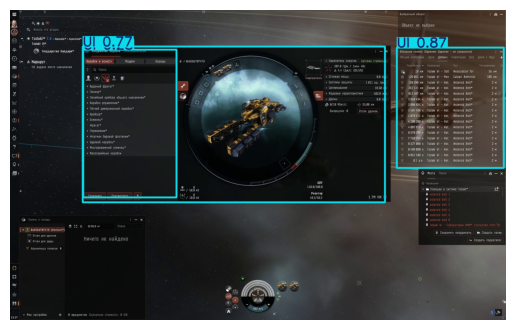

In [ ]:
from ultralytics.models import YOLO
from PIL import Image
from pathlib import Path
import os
from matplotlib import pyplot as plt

os.chdir("../../")

model = YOLO(
    r"D:\Projects\Eve-Online-Mining-Bot/Find interface elements/output_kaggle/results_v2/runs/y11s_custom/weights/best.pt"
)
res = model.predict(
    source=r"D:\Projects\Eve-Online-Mining-Bot\Find interface elements\data\output\images\frame_17193.jpg",
    imgsz=960,
    rect=True,
    conf=0.25,
)

r = res[0]
im_bgr = r.plot()  # аннотированное изображение в BGR (np.ndarray)
im_rgb = im_bgr[..., ::-1]  # в RGB для matplotlib

plt.imshow(im_rgb)
plt.axis("off")
plt.show()


In [5]:
import yaml

with open("..\data\config.yaml") as file:
    data = yaml.safe_load(file)

print(data)

{'path': '/kaggle/input/', 'train': ['eve-mining-asteroid/mining_asteroid_01/images/train', 'eve-ui-and-text/ui_01/images/train'], 'val': ['eve-mining-asteroid/mining_asteroid_01/images/val', 'eve-ui-and-text/ui_01/images/val'], 'names': {0: 'Text', 1: 'UI', 2: 'Asteroid', 3: 'My ship', 4: 'Ship', 5: 'Planet'}}


In [ ]:
import os, re, time, hashlib, mimetypes, pathlib
import requests

API_KEY = os.getenv("GOOGLE_API_KEY") or "YOUR_API_KEY"
CX = os.getenv("GOOGLE_CX") or "YOUR_CX"  # ID Programmable Search Engine
QUERY = "EVE Online UI icons"  # твой запрос
N = 200  # сколько изображений хотим
OUTDIR = "downloads_eve_images"

os.makedirs(OUTDIR, exist_ok=True)

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "img-downloader/1.0"})


def sanitize(name: str, maxlen=80):
    name = re.sub(r"[^\w\-_. ]+", "_", name).strip()
    return name[:maxlen] or "img"


def download(url: str, outdir: str, hint_title: str = ""):
    try:
        r = SESSION.get(url, timeout=15, stream=True)
        r.raise_for_status()
        ctype = r.headers.get("Content-Type", "")
        if not ctype.startswith(("image/", "application/octet-stream")):
            return False, f"skip content-type={ctype}"

        # имя файла по хэшу урла + расширение по mime (если есть)
        h = hashlib.sha1(url.encode("utf-8")).hexdigest()[:12]
        ext = mimetypes.guess_extension(ctype.split(";")[0].strip()) or ""
        title = sanitize(hint_title) if hint_title else h
        fname = f"{title}_{h}{ext}"
        path = os.path.join(outdir, fname)
        with open(path, "wb") as f:
            for chunk in r.iter_content(1 << 15):
                if chunk:
                    f.write(chunk)
        return True, path
    except Exception as e:
        return False, str(e)


def google_image_search(query: str, api_key: str, cx: str, start: int = 1):
    # см. cse.list + searchType=image
    # https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list
    url = "https://www.googleapis.com/customsearch/v1"
    params = {
        "key": api_key,
        "cx": cx,
        "q": query,
        "searchType": "image",
        "safe": "off",
        "start": start,  # 1..101 (макс 10 страниц * 10)
        "num": 10,  # 1..10
        # опционально: imgType, imgSize, rights, fileType, etc.
    }
    r = SESSION.get(url, params=params, timeout=15)
    r.raise_for_status()
    return r.json()


saved, start = 0, 1
seen_urls = set()

while saved < N and start <= 101:
    data = google_image_search(QUERY, API_KEY, CX, start=start)
    items = data.get("items") or []
    if not items:
        break

    for it in items:
        link = it.get("link")
        title = it.get("title") or ""
        if not link or link in seen_urls:
            continue
        ok, info = download(link, OUTDIR, hint_title=title)
        if ok:
            saved += 1
            print(f"[{saved}/{N}] {info}")
        else:
            print(f"[skip] {link} -> {info}")
        seen_urls.add(link)
        if saved >= N:
            break

    # следующий «пакет» (страница)
    start += 10
    time.sleep(0.3)  # чуть бережнее к лимитам

print(f"Done: saved {saved} files in {OUTDIR}")


<h1 style="color: #cd36d5ff">Pre-anotation для label-studio</h1>


In [ ]:
from ultralytics.models import YOLO
import json, os, glob

model = YOLO(
    r"D:\Projects\Eve-Online-Mining-Bot/Find interface elements/output_kaggle/results_v2/runs/y11s_custom/weights/best.pt"
)
images = r"D:\Datasets\EVE\mining_asteroid_02\mining_asteroid_01_0000000223.jpg"

results = model.predict(images, conf=0.10, save=False)

tasks = []
for r in results:
    h, w = r.orig_shape  # высота/ширина исходного изображения
    url_or_path = r.path  # подставь сюда URL, если импортируешь по URL
    result_items = []
    for b in r.boxes:
        x1, y1, x2, y2 = b.xyxy[0].tolist()
        cls = int(b.cls[0])
        label = model.names[cls]
        # Переводим в проценты для Label Studio (если используешь local file server/URL)
        value = {
            "x": x1 / w * 100,
            "y": y1 / h * 100,
            "width": (x2 - x1) / w * 100,
            "height": (y2 - y1) / h * 100,
            "rotation": 0,
            "rectanglelabels": [label],
        }
        result_items.append(
            {
                "from_name": "label",
                "to_name": "image",
                "type": "rectanglelabels",
                "value": value,
                "score": float(b.conf[0]),
            }
        )

    tasks.append(
        {"data": {"image": url_or_path}, "predictions": [{"result": result_items}]}
    )

with open("mining_asteroid_02.json", "w", encoding="utf-8") as f:
    json.dump(tasks, f, ensure_ascii=False)



image 1/1 D:\Datasets\EVE\mining_asteroid_02\mining_asteroid_01_0000000223.jpg: 608x960 1 UI, 251.8ms
Speed: 8.2ms preprocess, 251.8ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 960)
